El siguiente es un ejemplo de cómo se aplica GMM con una muestra unidimensional de datos.
-----
Primero declaramos todas las bibliotecas que utilizaremos en el ejercicio.

In [1]:
#Biblioteca para graficar
import matplotlib.pyplot as plt 

#Biblioteca fundamental para la computación científica
import numpy as np              

#Extensión de numpy, con modelos estadísticos
from scipy import stats     

#Biblioteca basada en matplotlib, especializada en gráficos estadísticos
import seaborn as sns 

#Biblioteca para la manipulación y análisis de datos
import pandas as pd

#Operaciones matemáticas
from math import sqrt, log, exp, pi

#uniform retorna un valor aleatorio dentro de un intervalo
from random import uniform

sns.set_style("white")
%matplotlib inline

Para este ejemplo, se utilizará un conjunto de datos bimodal.

In [2]:
df = pd.read_csv("bimodal_example.csv")
df.head(n=5)

,x
0,0.252851
1,-1.034562
2,3.319558
3,4.552363
4,-0.775995


In [3]:
data = df.x

Desplegamos los datos en una gráfica para poder apreciar su comportamiento.

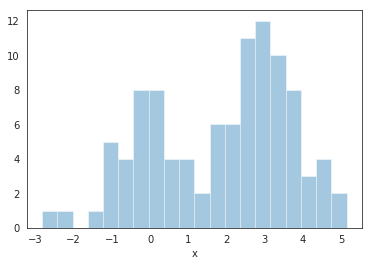

In [4]:
sns.distplot(data,
             bins=20,
             kde=False);

Claramente podemos ver que, a pesar de que podríamos aproximar las probabilidades en una curva normal, resulta una aproximación pobre.

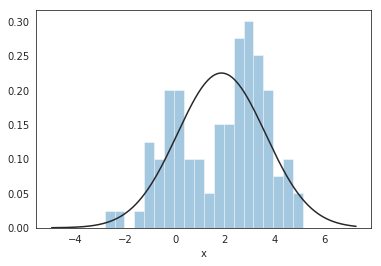

In [5]:
sns.distplot(data,
             fit=stats.norm,
             bins=20,
             kde=False,);

Es por ello que debemos convertir esta curva de probabilidades a una mezcla gaussiana. Por las crestas en los datos, podemos inferir que una mezcla de dos gaussianas sería una eproximación cercana.

Para empezar, debemos programar cómo se comportaría una distribución gaussiana, la cual tiene como parámetros $N(\mu, \sigma^2)$ 
La siguiente clase representa una distribución gaussiana. Dicha clase tiene los métodos "init" con los parámetros mu y sigma, la función de densidad de probabilidad (pdf) y la función "repr" que imprime en pantalla los parámetros de la gaussiana.

In [6]:
class Gaussian:
    "Model univariate Gaussian"

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y

    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

Ya que tenemos lista una clase para la distribución gaussiana, requerimos de una clase para crear la mezcla gaussiana de las dos clases de los datos de entrada. La siguiente clase representa GMM para dos gaussianas.
Entre sus métodos se encuentran los pasos E y M del algoritmo Expectativa-Maximización. 

In [7]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den
            wp2 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2)
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(rigt, data))
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

Ahora que ya contamos con las dos clases, tanto GaussianMixture como Gaussian, es momento de implementar la mezcla. Sin embargo, es recomendable que antes de realizar la mezcla gaussiana, se pruebe si la estimación de las mezclas es posible. ¿Cómo podemos apreciar eso? Si realizamos un par de iteraciones de prueba y vemos que los parámetros estimados convergen, podemos proceder a realizar la mezcla Gaussiana.
Seguimos la siguiente secuencia de pasos para la breve prueba:

1. Definimos el número de iteraciones.
2. Creamos las variable requeridas para iniciar el proceso. 

    2.1. best_mix es la variable donde colocaremos la mejor mezcla.
    
    2.2. best_loglike es la variable donde colocaremos la probabilidad que mejor se aproxime entre las mezclas. Es la variable que nos indica si una mezcla es mejor que otra.
    
    2.2. mix guarda la mezcla donde se llevarán las iteraciones.    
    
3. Realizamos la mezcla 

Si los valores estimados de cada gaussiana son consistentes, es decir, no varían de forma significativa entre ellos con sus iteraciones anteriores, podemos afirmar que convergen.

In [8]:
# Check out the fitting process
n_iterations = 5
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture(data)
for _ in range(n_iterations):
    try:
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        pass

 1 Mixture: Gaussian(1.18615, 1.51252), Gaussian(3.86087, 0.53598), mix=0.747)
 1 Mixture: Gaussian(1.273, 1.61308), Gaussian(3.69025, 0.602872), mix=0.756)
 1 Mixture: Gaussian(1.28997, 1.66129), Gaussian(3.55661, 0.632147), mix=0.747)
 1 Mixture: Gaussian(1.27899, 1.68998), Gaussian(3.45733, 0.646924), mix=0.732)
 1 Mixture: Gaussian(1.25485, 1.70802), Gaussian(3.38569, 0.656165), mix=0.715)


Ya que los valores convergen, ahora podemos realizar la verdadera mezcla gaussiana, con un número de iteraciones mayor y con un número de reinicios aleatorios.

In [13]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')

Computing best model with random restarts...



Done. 🙂


Al desplegar la nueva mezcla, podemos observar que se aproxima mejor a los datos.

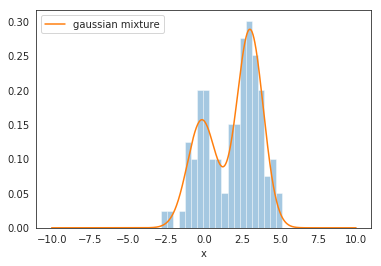

In [14]:
sns.distplot(data, bins=20, kde=False, norm_hist=True)
x = np.linspace(start=-10, stop=10, num=1000)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();

Ejercicio
----

Ejecuta nuevamente mezcla gaussiana pero ahora con el archivo bimodal_example2.csv. Ejecuta el programa 8 veces, observa el gráfico resultante de cada ejecución y responde:
1. ¿Es el mismo siempre? ¿Por qué?
2. ¿De qué manera esto puede afectar el resultado del algoritmo?
3. ¿En qué circunstancias piensas que debería ser utilizado GMM?

Reto
----
El algoritmo de GMM es una buena elección para clasificar, incluso con el problema de la clasificación de flores entre setosa, versicolor y virginica.
Modifica el código presente para resolver el problema de la clasificación de dichas flores. En lugar de ser una clasificación unidimensional como en los ejemplos presentes, la clasificación de las flores es un problema que presenta 4 dimensiones (largo y ancho de sépalo y pétalo).
Puedes encontrar el csv de las flores dentro de este proyecto con el nombre flowers.csv